## Setup

First, import all neccessary packages and define all the variables.

In [1]:
import os
import pandas as pd
import qiime2 as q2
from qiime2 import Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline

In [2]:
#all variables
data_classified = 'Data/classified'
data_raw = 'Data/raw'
data_alpha = 'Data/diversity'
data_abundance ='Data/abundance'

The biggest differences were found between the sterile and non-sterile environment during beta diversity analysis, so these will be looked at. 

In [5]:
#First, we look at the distribution of our data. 
data = q2.Artifact.load(f'{data_raw}/modified-dada1-table-highschool.qza').view(pd.DataFrame)

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [6]:
data.shape

(548, 19899)

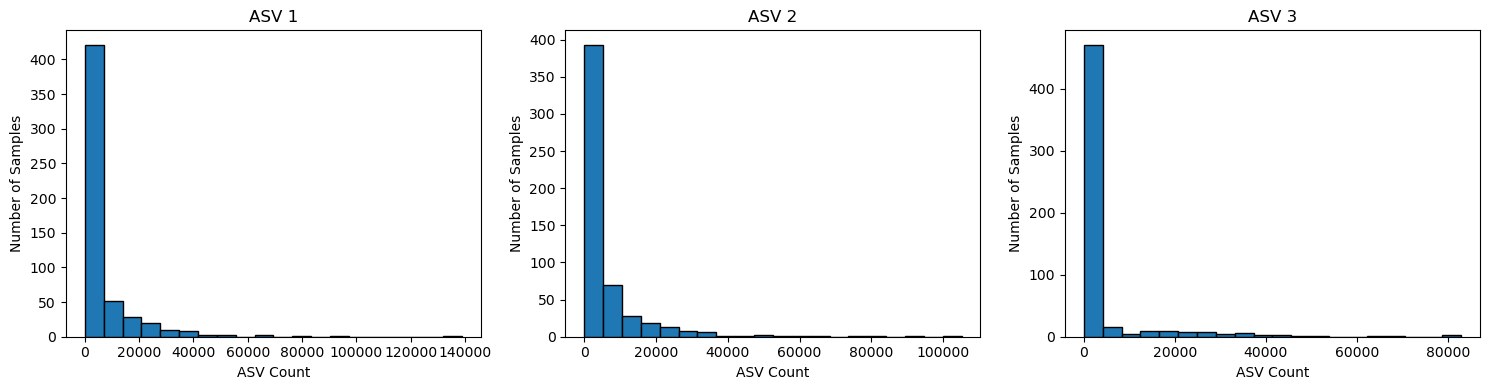


Top 3 ASV identifiers:
1. f228dd6b54c8587a0e366a57ab4d0904 (total: 3150979.0)
2. 23f8d77e0da2129f8b93b5ca894b5771 (total: 3065488.0)
3. c1f82285dd8e54d0759cc5b4589bd81e (total: 1907950.0)


In [7]:
data
# Get the top three most abundant sequence variants
# based on sum of observed sequence counts. Create a dataframe of ASV counts 
# with samples as rows and sequence variants as columns.
top_three = data[data.sum().nlargest(3).index]
# Your turn to try! Now view each of them as a histogram, as number of samples per ASV.
# View each as a histogram showing number of samples per ASV count value
import matplotlib.pyplot as plt

top_asv_names = top_three.columns

fig, axes = plt.subplots(1, 3, figsize=(15, 4))


for i, asv in enumerate(top_asv_names):
    axes[i].hist(top_three[asv], bins=20, edgecolor='black')
    axes[i].set_xlabel('ASV Count')
    axes[i].set_ylabel('Number of Samples')
    axes[i].set_title(f'ASV {i+1}')

plt.tight_layout()
plt.show()

# Print the actual ASV identifiers
print("\nTop 3 ASV identifiers:")
for i, asv in enumerate(top_asv_names, 1):
    print(f"{i}. {asv} (total: {data[asv].sum()})")

## Filtering and ANCOM BC for sterile vs non-sterile evironment

Based on the shape of the data and the distribution of above, the following parameters for
filtering were chosen:

In [16]:

! qiime feature-table filter-features \
  --i-table $data_classified/table-filtered.qza \
  --p-min-frequency 50 \
  --p-min-samples 10 \
  --o-filtered-table $data_abundance/table_abund.qza

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved FeatureTable[Frequency] to: Data/abundance/table_abund.qza


In [7]:
#Check if there are any other values than sterile and non-sterile in the merged metadata in the background column
md_merged = pd.read_csv(f'{data_raw}/merged_output_usable.tsv', sep='\t')
md_merged['background'].unique()

array(['non-sterile', 'sterile', nan], dtype=object)

We want to look at differences betwen non-sterile and sterile environment since nan values are in df, filter for sterile and non-sterile values.

In [8]:

! qiime feature-table filter-samples \
    --i-table $data_abundance/table_abund.qza \
    --m-metadata-file $data_raw/merged_output_usable.tsv \
    --p-where "[background]='sterile' OR [background]='non-sterile'" \
    --o-filtered-table $data_abundance/table_abund_sterile_nonsterile.qza

#make it into a visualization
! qiime feature-table summarize \
    --i-table $data_abundance/table_abund_sterile_nonsterile.qza \
    --m-sample-metadata-file $data_raw/merged_output_usable.tsv \
    --o-visualization $data_abundance/table_abund_sterile_nonsterile.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved FeatureTable[Frequency] to: Data/abundance/table_abund_sterile_nonsterile.qza
/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: Data/abundance/table_abund_sterile_nonsterile.qzv


In [21]:

# Run ANCOM-BC to test which ASVs differ between sterile and non-sterile
#first we start with an overall background comparison
! qiime composition ancombc \
    --i-table $data_abundance/table_abund_sterile_nonsterile.qza \
    --m-metadata-file $data_raw/merged_output_usable.tsv \
    --p-formula background \
    --o-differentials $data_abundance/ancombc_sterile_nonsterile_differentials.qza

# Generate a barplot of differentially abundant taxa between sterile and non-sterile backgrounds
! qiime composition da-barplot \
    --i-data $data_abundance/ancombc_sterile_nonsterile_differentials.qza \
    --o-visualization $data_abundance/ancombc_sterile_nonsterile_da_barplot.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved FeatureData[DifferentialAbundance] to: Data/abundance/ancombc_sterile_nonsterile_differentials.qza


In [3]:

Visualization.load(f"{data_abundance}/ancombc_sterile_nonsterile_da_barplot.qzv")

<visualization: Visualization uuid: 7ed5166e-a4a4-4533-8e97-e08219b98ac5>

## ANCOM BC to see differences on species between sterile and non-sterile over time

Now we did a general analysis, and saw there were definetly some samples
enriched vs. depleted in the analysis. Now we want to try and answer the 
following questions by differential abundance: 
2. How did the fungal communities change over time between sterile vs.
non-sterile starter backgrounds? Is one background more ‘resilient’ towards
invading fungi directly coming from participants' hands?
3. Which taxa consistently transfer from hand to dough — and which resist
colonization?

We try to answer this question first:  2. How did the fungal communities change over time between sterile vs.
non-sterile starter backgrounds? Is one background more ‘resilient’ towards
invading fungi directly coming from participants' hands?
For this, we want to run a ANCOM bc test between sterile vs non-sterile background
at the different time points (we have the time points 0, 7, 14 and 21)

In [33]:
#Some data in the day column are empty, so first we need to filter the metadata df for only 
#data where there is a time point
md_time = pd.read_csv(f'{data_raw}/merged_output_usable.tsv', sep='\t')
# Drop rows where 'day' column is missing/empty
md_time = md_time[md_time['day'].notna()].copy()
# Save to new file
md_time.to_csv(f'{data_raw}/md_time.tsv', sep='\t', index=False)

For loop through each time point, to run ANCOM BC test at each time point for sterile 
and non-sterile environment. 

In [35]:


# Different time points 
days = [0, 7, 14, 21]

# Loop through each day
for day in days:
    print(f"Processing day {day}...")
    
    # Filter for current day samples
    os.system(f"""qiime feature-table filter-samples \
        --i-table {data_abundance}/table_abund_sterile_nonsterile.qza \
        --m-metadata-file {data_raw}/md_time.tsv \
        --p-where "[day]='{day}'" \
        --o-filtered-table {data_abundance}/table_abund_sterile_nonsterile_day{day}.qza""")
    
    # Run ANCOM-BC on current day
    os.system(f"""qiime composition ancombc \
        --i-table {data_abundance}/table_abund_sterile_nonsterile_day{day}.qza \
        --m-metadata-file {data_raw}/md_time.tsv \
        --p-formula background \
        --o-differentials {data_abundance}/ancombc_sterile_nonsterile_day{day}_differentials.qza""")
    
    print(f"Completed day {day}\n")

print("All days processed!")

Processing day 0...


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Saved FeatureTable[Frequency] to: Data/abundance/table_abund_sterile_nonsterile_day0.qza


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Saved FeatureData[DifferentialAbundance] to: Data/abundance/ancombc_sterile_nonsterile_day0_differentials.qza
Completed day 0

Processing day 7...


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Saved FeatureTable[Frequency] to: Data/abundance/table_abund_sterile_nonsterile_day7.qza


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Saved FeatureData[DifferentialAbundance] to: Data/abundance/ancombc_sterile_nonsterile_day7_differentials.qza
Completed day 7

Processing day 14...


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Saved FeatureTable[Frequency] to: Data/abundance/table_abund_sterile_nonsterile_day14.qza


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Saved FeatureData[DifferentialAbundance] to: Data/abundance/ancombc_sterile_nonsterile_day14_differentials.qza
Completed day 14

Processing day 21...


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Saved FeatureTable[Frequency] to: Data/abundance/table_abund_sterile_nonsterile_day21.qza


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Saved FeatureData[DifferentialAbundance] to: Data/abundance/ancombc_sterile_nonsterile_day21_differentials.qza
Completed day 21

All days processed!


In [ ]:
#Export the results of each time point
import os

# Export each time point's results
days = [0, 7, 14, 21]
for day in days:
    os.system(f"""
        qiime tools export \
            --input-path {data_abundance}/ancombc_sterile_nonsterile_day{day}_differentials.qza \
            --output-path {data_abundance}/exported_day{day}
    """)

In [10]:
days = [0, 7, 14, 21] 
# Load the differential abundance results for each time point 
results = {} for day in days: 
# Read all the slice files
lfc = pd.read_csv(f"{data_abundance}/exported_day{day}/lfc_slice.csv", index_col=0)
p_val = pd.read_csv(f"{data_abundance}/exported_day{day}/p_val_slice.csv", index_col=0) 
q_val = pd.read_csv(f"{data_abundance}/exported_day{day}/q_val_slice.csv", index_col=0) 
se = pd.read_csv(f"{data_abundance}/exported_day{day}/se_slice.csv", index_col=0)
w = pd.read_csv(f"{data_abundance}/exported_day{day}/w_slice.csv", index_col=0) 
# Combine into one dataframe
df = pd.DataFrame({ 'lfc': lfc.iloc[:, 0], 'p_val': p_val.iloc[:, 0], 'q_val': q_val.iloc[:, 0], 'se': se.iloc[:, 0], 'w': w.iloc[:, 0] }) 
df.index.name = 'id' df = df.reset_index()
results[day] = df

## Analysis on the species level

Now, let's do the same with species identification. For this we need to collapse the 
table on species level. 

In [34]:

! qiime taxa collapse \
    --i-table $data_abundance/table_abund.qza \
    --i-taxonomy $data_classified/taxonomy.qza \
    --p-level 7 \
    --o-collapsed-table $data_abundance/table_abund_l7.qza

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved FeatureTable[Frequency] to: Data/abundance/table_abund_l7.qza


Run ANCOM BC on species level for all the different time points.

In [ ]:
import os

# Define the days to process
days = [0, 7, 14, 21]

# Loop through each day
for day in days:
    print(f"Processing day {day}...")
    
    # Filter for current day samples
    status1 = os.system(f"""qiime feature-table filter-samples \
        --i-table {data_abundance}/table_abund_l7.qza \
        --m-metadata-file {data_raw}/md_time.tsv \
        --p-where "[day]='{day}'" \
        --o-filtered-table {data_abundance}/table_abund_sterile_nonsterile_l7_day{day}.qza""")
    
    if status1 != 0:
        print(f"Error filtering day {day}")
        continue
    
    # Run ANCOM-BC on current day
    status2 = os.system(f"""qiime composition ancombc \
        --i-table {data_abundance}/table_abund_sterile_nonsterile_l7_day{day}.qza \
        --m-metadata-file {data_raw}/md_time.tsv \
        --p-formula background \
        --o-differentials {data_abundance}/ancombc_sterile_nonsterile_l7_day{day}_differentials.qza""")
    
    if status2 != 0:
        print(f"Error running ANCOM-BC for day {day}")
    else:
        print(f"✓ Completed day {day}\n")

print("All days processed!")

Processing day 0...


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Saved FeatureTable[Frequency] to: Data/abundance/table_abund_sterile_nonsterile_l7_day0.qza


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Saved FeatureData[DifferentialAbundance] to: Data/abundance/ancombc_sterile_nonsterile_l7_day0_differentials.qza
✓ Completed day 0

Processing day 7...


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Saved FeatureTable[Frequency] to: Data/abundance/table_abund_sterile_nonsterile_l7_day7.qza


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources

Aborted!


Error running ANCOM-BC for day 7
Processing day 14...


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Saved FeatureTable[Frequency] to: Data/abundance/table_abund_sterile_nonsterile_l7_day14.qza


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [16]:


# Export each time point's results
days = [0, 7, 14, 21]

for day in days:
    print(f"Exporting day {day} results...")
    
    status = os.system(f"""qiime tools export \
        --input-path {data_abundance}/ancombc_sterile_nonsterile_l7_day{day}_differentials.qza \
        --output-path {data_abundance}/exported_l7_day{day}""")
    
    if status != 0:
        print(f"Error exporting day {day}")
    else:
        print(f"✓ Exported day {day}\n")

print("All exports completed!")

Exporting day 0 results...


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Exported Data/abundance/ancombc_sterile_nonsterile_l7_day0_differentials.qza as DataLoafPackageDirFmt to directory Data/abundance/exported_l7_day0
✓ Exported day 0

Exporting day 7 results...


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Exported Data/abundance/ancombc_sterile_nonsterile_l7_day7_differentials.qza as DataLoafPackageDirFmt to directory Data/abundance/exported_l7_day7
✓ Exported day 7

Exporting day 14 results...


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Exported Data/abundance/ancombc_sterile_nonsterile_l7_day14_differentials.qza as DataLoafPackageDirFmt to directory Data/abundance/exported_l7_day14
✓ Exported day 14

Exporting day 21 results...


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Exported Data/abundance/ancombc_sterile_nonsterile_l7_day21_differentials.qza as DataLoafPackageDirFmt to directory Data/abundance/exported_l7_day21
✓ Exported day 21

All exports completed!


In [22]:
# Load the differential species abundance results for each time point
days = [0, 7, 14, 21]
results_species_level = {}

for day in days:
    lfc = pd.read_csv(f"{data_abundance}/exported_l7_day{day}/lfc_slice.csv", index_col=0)
    p_val = pd.read_csv(f"{data_abundance}/exported_l7_day{day}/p_val_slice.csv", index_col=0)
    q_val = pd.read_csv(f"{data_abundance}/exported_l7_day{day}/q_val_slice.csv", index_col=0)
    se = pd.read_csv(f"{data_abundance}/exported_l7_day{day}/se_slice.csv", index_col=0)
    w = pd.read_csv(f"{data_abundance}/exported_l7_day{day}/w_slice.csv", index_col=0)
    
    df = pd.DataFrame({
        'lfc': lfc.iloc[:, 0],
        'p_val': p_val.iloc[:, 0],
        'q_val': q_val.iloc[:, 0],
        'se': se.iloc[:, 0],
        'w': w.iloc[:, 0]
    })
    df.index.name = 'id'
    df = df.reset_index()
    results_species_level[day] = df

## ANCOM BC analysis for hand and sourdough over time

First, check if there are differences between hand and sourdough.

In [8]:

#check for unique values in the sample_type column
md_merged['sample_type'].unique()

array(['sourdough', 'control_n', 'control_pcr', 'control_p', 'empty',
       'hand_swabs'], dtype=object)

In [25]:

#Filter for hand_swabs and sourdough samples
! qiime feature-table filter-samples \
    --i-table $data_abundance/table_abund.qza \
    --m-metadata-file $data_raw/merged_output_usable.tsv \
    --p-where "[sample_type]='hand_swabs' OR [sample_type]='sourdough'" \
    --o-filtered-table $data_abundance/table_hand_dough.qza

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved FeatureTable[Frequency] to: Data/abundance/table_hand_dough.qza


In [4]:
! qiime composition ancombc \
    --i-table $data_abundance/table_hand_dough.qza \
    --m-metadata-file $data_raw/merged_output_usable.tsv \
    --p-formula "sample_type" \
    --p-reference-levels "sample_type::hand_swabs" \
    --o-differentials $data_abundance/table_hand_dough_person_filtered.qza

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved FeatureData[DifferentialAbundance] to: Data/abundance/table_hand_dough_person_filtered.qza


In [5]:
#turn into visualization 
! qiime composition tabulate \
    --i-data $data_abundance/table_hand_dough_person_filtered.qza \
    --o-visualization $data_abundance/table_hand_dough_person_filtered.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: Data/abundance/table_hand_dough_person_filtered.qzv


In [7]:
#Visualize
! qiime composition da-barplot \
    --i-data $data_abundance/table_hand_dough_person_filtered.qza \
    --o-visualization $data_abundance/ancombc_hand_dough_barplot.qzv


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: Data/abundance/ancombc_hand_dough_barplot.qzv


In [9]:
Visualization.load(f"Data/abundance/table_hand_dough_person_filtered.qzv")

<visualization: Visualization uuid: 6073e2d3-2d82-4e38-9076-f4bc7078c503>

In [10]:
Visualization.load(f"Data/abundance/ancombc_hand_dough_barplot.qzv")

<visualization: Visualization uuid: 7f0b92d8-1602-4920-bf40-9cbaf8377179>

## ANCOM BC analysis for sourdough vs hand over time in sterile and non-sterile background

We saw that there is a difference between hand and sourdough taxa. Now we want to compare the hand and sourdough taxa over time in the sterile vs non-sterile environment. For this we once do the ANCOM BC test for the sterile environment and once for the non-sterile environment. 

### Sterile environment

In [11]:
#Looping through the different time points again for sourdough vs. hand_swabs for 
#the sterile environment

# Define the days to process
days = [0, 7, 14, 21]

# Loop through each day
for day in days:
    print(f"Processing day {day}...")
    
    # Filter for current day samples (hand_swabs and sourdough only, sterile background)
    status1 = os.system(f"""qiime feature-table filter-samples \
        --i-table {data_abundance}/table_abund_l7.qza \
        --m-metadata-file {data_raw}/md_time.tsv \
        --p-where "[day]='{day}' AND ([sample_type]='hand_swabs' OR [sample_type]='sourdough') AND [background]='sterile'" \
        --o-filtered-table {data_abundance}/table_abund_hand_vs_sourdough_l7_day{day}.qza""")
    
    if status1 != 0:
        print(f"Error filtering day {day}")
        continue
    
    # Run ANCOM-BC on current day (comparing sample_type instead of background)
    status2 = os.system(f"""qiime composition ancombc \
        --i-table {data_abundance}/table_abund_hand_vs_sourdough_l7_day{day}.qza \
        --m-metadata-file {data_raw}/md_time.tsv \
        --p-formula sample_type \
        --o-differentials {data_abundance}/ancombc_l7_sterile_day{day}_differentials.qza""")
    
    if status2 != 0:
        print(f"Error running ANCOM-BC for day {day}")
    else:
        print(f"✓ Completed day {day}\n")

print("All days processed!")

Processing day 0...


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Saved FeatureTable[Frequency] to: Data/abundance/table_abund_hand_vs_sourdough_l7_day0.qza


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Plugin error from composition:

  An error was encountered while running ANCOM-BC in R (return code 1), please inspect stdout and stderr to learn more.

Debug info has been saved to /tmp/qiime2-q2cli-err-fhj4ju_t.log


Error running ANCOM-BC for day 0
Processing day 7...


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Saved FeatureTable[Frequency] to: Data/abundance/table_abund_hand_vs_sourdough_l7_day7.qza


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Saved FeatureData[DifferentialAbundance] to: Data/abundance/ancombc_l7_sterile_day7_differentials.qza
✓ Completed day 7

Processing day 14...


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Saved FeatureTable[Frequency] to: Data/abundance/table_abund_hand_vs_sourdough_l7_day14.qza


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Saved FeatureData[DifferentialAbundance] to: Data/abundance/ancombc_l7_sterile_day14_differentials.qza
✓ Completed day 14

Processing day 21...


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Saved FeatureTable[Frequency] to: Data/abundance/table_abund_hand_vs_sourdough_l7_day21.qza


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Saved FeatureData[DifferentialAbundance] to: Data/abundance/ancombc_l7_sterile_day21_differentials.qza
✓ Completed day 21

All days processed!


In [ ]:
There is no data for the sourdoughs from day 0, so day 0 will be excluded from the analysis. 

In [13]:
# Export each time point's results for sterile environment
days = [7, 14, 21]
for day in days:
    print(f"Exporting day {day} results...")
    
    status = os.system(f"""qiime tools export \
        --input-path {data_abundance}/ancombc_l7_sterile_day{day}_differentials.qza \
        --output-path {data_abundance}/exported_l7_sterile_day{day}""")
    
    if status != 0:
        print(f"Error exporting day {day}")
    else:
        print(f"✓ Exported day {day}\n")
print("All exports completed!")

Exporting day 7 results...


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Exported Data/abundance/ancombc_l7_sterile_day7_differentials.qza as DataLoafPackageDirFmt to directory Data/abundance/exported_l7_sterile_day7
✓ Exported day 7

Exporting day 14 results...


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Exported Data/abundance/ancombc_l7_sterile_day14_differentials.qza as DataLoafPackageDirFmt to directory Data/abundance/exported_l7_sterile_day14
✓ Exported day 14

Exporting day 21 results...


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Exported Data/abundance/ancombc_l7_sterile_day21_differentials.qza as DataLoafPackageDirFmt to directory Data/abundance/exported_l7_sterile_day21
✓ Exported day 21

All exports completed!


In [14]:
#Load the results into pandas
results_species_level_sterile = {}
for day in days:
    lfc = pd.read_csv(f"{data_abundance}/exported_l7_sterile_day{day}/lfc_slice.csv", index_col=0)
    p_val = pd.read_csv(f"{data_abundance}/exported_l7_sterile_day{day}/p_val_slice.csv", index_col=0)
    q_val = pd.read_csv(f"{data_abundance}/exported_l7_sterile_day{day}/q_val_slice.csv", index_col=0)
    se = pd.read_csv(f"{data_abundance}/exported_l7_sterile_day{day}/se_slice.csv", index_col=0)
    w = pd.read_csv(f"{data_abundance}/exported_l7_sterile_day{day}/w_slice.csv", index_col=0)
    
    df = pd.DataFrame({
        'lfc': lfc.iloc[:, 0],
        'p_val': p_val.iloc[:, 0],
        'q_val': q_val.iloc[:, 0],
        'se': se.iloc[:, 0],
        'w': w.iloc[:, 0]
    })
    df.index.name = 'id'
    df = df.reset_index()
    results_species_level_sterile[day] = df


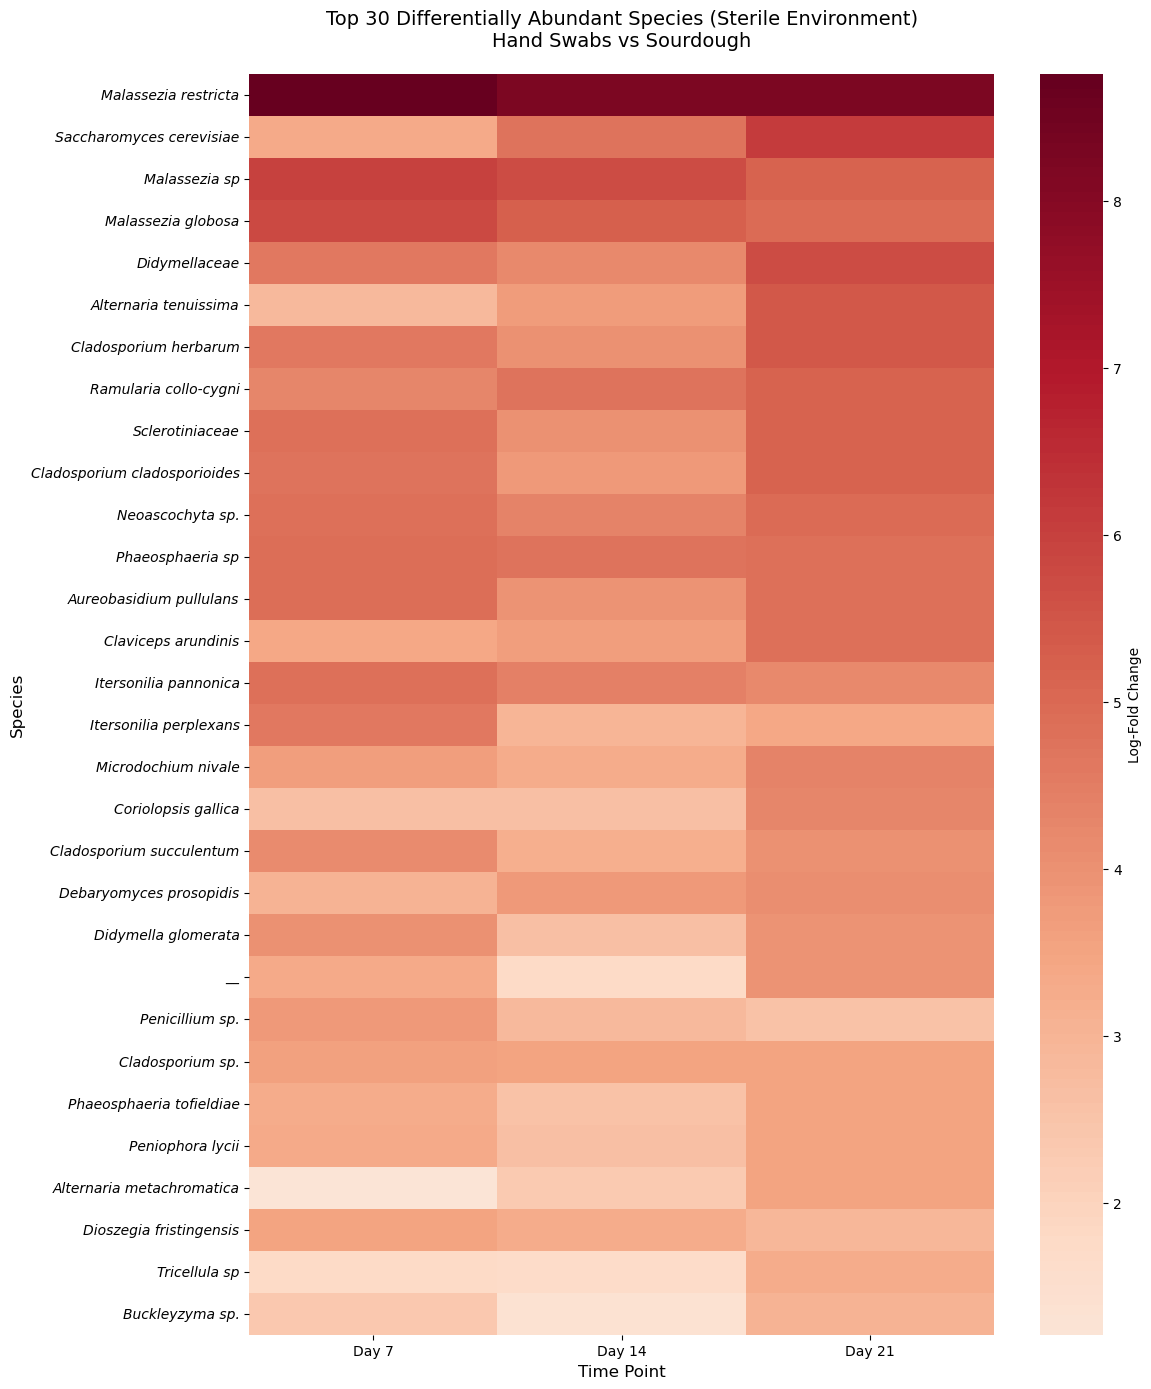

In [19]:
#Create heatmap
# Combine all days and identify top 30 species by absolute log-fold change (STERILE)
all_species_sterile = []
for day, df in results_species_level_sterile.items():
    df_sig = df[df['q_val'] < 0.05].copy()
    df_sig['abs_lfc'] = df_sig['lfc'].abs()
    df_sig['day'] = day
    all_species_sterile.append(df_sig)

combined_sterile = pd.concat(all_species_sterile)
top_species_sterile = combined_sterile.groupby('id')['abs_lfc'].max().nlargest(30).index

# Create matrix for heatmap (rows = species, columns = days)
heatmap_data_sterile = pd.DataFrame(index=top_species_sterile, columns=days)
for day in days:
    df = results_species_level_sterile[day].set_index('id')
    for species in top_species_sterile:
        if species in df.index:
            heatmap_data_sterile.loc[species, day] = df.loc[species, 'lfc']
        else:
            heatmap_data_sterile.loc[species, day] = 0

heatmap_data_sterile = heatmap_data_sterile.astype(float)

# Extract only genus and species from the full taxonomy
def extract_genus_species(full_taxonomy):
    """Extract genus and species from full taxonomy string, showing species epithet only"""
    parts = full_taxonomy.split(';')
    genus = ''
    species = ''
    family = ''
    
    for part in parts:
        part = part.strip()
        if part.startswith('f__'):
            family = part.replace('f__', '').strip()
        elif part.startswith('g__'):
            genus = part.replace('g__', '').strip()
        elif part.startswith('s__'):
            species_full = part.replace('s__', '').strip()
            # Extract only the species epithet (second word)
            species_parts = species_full.split('_')
            if len(species_parts) >= 2:
                species = species_parts[1]  # Get second part (species epithet)
            else:
                species = species_full
    
    if genus and species:
        return f"{genus} {species}"
    elif genus:
        return f"{genus} sp."  # Genus level only
    elif family:
        return family  # Family level only
    else:
        # If nothing found, return last identifiable part
        return full_taxonomy.split(';')[-1].strip()

# Create simplified labels
simplified_labels = [extract_genus_species(tax) for tax in heatmap_data_sterile.index]

# Create the heatmap for sterile environment
plt.figure(figsize=(12, 14))
ax = sns.heatmap(heatmap_data_sterile, cmap='RdBu_r', center=0, 
            cbar_kws={'label': 'Log-Fold Change'},
            xticklabels=[f'Day {d}' for d in days],
            yticklabels=simplified_labels)

# Make species names italic
for label in ax.get_yticklabels():
    label.set_fontstyle('italic')

plt.title('Top 30 Differentially Abundant Species (Sterile Environment)\nHand Swabs vs Sourdough', 
          fontsize=14, pad=20)
plt.xlabel('Time Point', fontsize=12)
plt.ylabel('Species', fontsize=12)
plt.tight_layout()
plt.show()


### Non-sterile environment

In [ ]:
#And once for the non-sterile environment
# Define the days to process
days = [7, 14, 21]

# Loop through each day
for day in days:
    print(f"Processing day {day}...")
    
    # Filter for current day samples (hand_swabs and sourdough only, non-sterile background)
    status1 = os.system(f"""qiime feature-table filter-samples \
        --i-table {data_abundance}/table_abund_l7.qza \
        --m-metadata-file {data_raw}/md_time.tsv \
        --p-where "[day]='{day}' AND ([sample_type]='hand_swabs' OR [sample_type]='sourdough') AND [background]='non-sterile'" \
        --o-filtered-table {data_abundance}/table_abund_hand_vs_sourdough_l7_day{day}.qza""")
    
    if status1 != 0:
        print(f"Error filtering day {day}")
        continue
    
    # Run ANCOM-BC on current day (comparing sample_type instead of background)
    status2 = os.system(f"""qiime composition ancombc \
        --i-table {data_abundance}/table_abund_hand_vs_sourdough_l7_day{day}.qza \
        --m-metadata-file {data_raw}/md_time.tsv \
        --p-formula sample_type \
        --o-differentials {data_abundance}/ancombc_non_sterile_day{day}_differentials.qza""")
    
    if status2 != 0:
        print(f"Error running ANCOM-BC for day {day}")
    else:
        print(f"✓ Completed day {day}\n")

print("All days processed!")

Processing day 7...


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Saved FeatureTable[Frequency] to: Data/abundance/table_abund_hand_vs_sourdough_l7_day7.qza


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Saved FeatureData[DifferentialAbundance] to: Data/abundance/ancombc_non_sterile_day7_differentials.qza
✓ Completed day 7

Processing day 14...


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Saved FeatureTable[Frequency] to: Data/abundance/table_abund_hand_vs_sourdough_l7_day14.qza


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Saved FeatureData[DifferentialAbundance] to: Data/abundance/ancombc_non_sterile_day14_differentials.qza
✓ Completed day 14

Processing day 21...


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Saved FeatureTable[Frequency] to: Data/abundance/table_abund_hand_vs_sourdough_l7_day21.qza


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [20]:

# Export each time point's results for non-sterile environment
days = [7, 14, 21]
for day in days:
    print(f"Exporting day {day} results...")
    
    status = os.system(f"""qiime tools export \
        --input-path {data_abundance}/ancombc_non_sterile_day{day}_differentials.qza \
        --output-path {data_abundance}/exported_non_sterile_day{day}""")
    
    if status != 0:
        print(f"Error exporting day {day}")
    else:
        print(f"✓ Exported day {day}\n")
print("All exports completed!")

Exporting day 0 results...
Error exporting day 0
Exporting day 7 results...


Usage: qiime tools export [OPTIONS]

  Exporting extracts (and optionally transforms) data stored inside an
  Artifact or Visualization. Note that Visualizations cannot be transformed
  with --output-format

Options:
  --input-path ARTIFACT/VISUALIZATION
                        Path to file that should be exported        [required]
  --output-path PATH    Path to file or directory where data should be
                        exported to                                 [required]
  --output-format TEXT  Format which the data should be exported as. This
                        option cannot be used with Visualizations
  --help                Show this message and exit.

                    There was a problem with the command:                     
 (1/1) Invalid value for '--input-path': File
  'Data/abundance/ancombc_non_sterile_day0_differentials.qza' does not exist.
/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See h

Exported Data/abundance/ancombc_non_sterile_day7_differentials.qza as DataLoafPackageDirFmt to directory Data/abundance/exported_non_sterile_day7
✓ Exported day 7

Exporting day 14 results...


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Exported Data/abundance/ancombc_non_sterile_day14_differentials.qza as DataLoafPackageDirFmt to directory Data/abundance/exported_non_sterile_day14
✓ Exported day 14

Exporting day 21 results...


/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Exported Data/abundance/ancombc_non_sterile_day21_differentials.qza as DataLoafPackageDirFmt to directory Data/abundance/exported_non_sterile_day21
✓ Exported day 21

All exports completed!


In [24]:
# Load the results into pandas for non-sterile environment
results_species_level_non_sterile = {}
days = [7, 14, 21]
for day in days:
    lfc = pd.read_csv(f"{data_abundance}/exported_non_sterile_day{day}/lfc_slice.csv", index_col=0)
    p_val = pd.read_csv(f"{data_abundance}/exported_non_sterile_day{day}/p_val_slice.csv", index_col=0)
    q_val = pd.read_csv(f"{data_abundance}/exported_non_sterile_day{day}/q_val_slice.csv", index_col=0)
    se = pd.read_csv(f"{data_abundance}/exported_non_sterile_day{day}/se_slice.csv", index_col=0)
    w = pd.read_csv(f"{data_abundance}/exported_non_sterile_day{day}/w_slice.csv", index_col=0)
    
    df = pd.DataFrame({
        'lfc': lfc.iloc[:, 0],
        'p_val': p_val.iloc[:, 0],
        'q_val': q_val.iloc[:, 0],
        'se': se.iloc[:, 0],
        'w': w.iloc[:, 0]
    })
    df.index.name = 'id'
    df = df.reset_index()
    results_species_level_non_sterile[day] = df
    

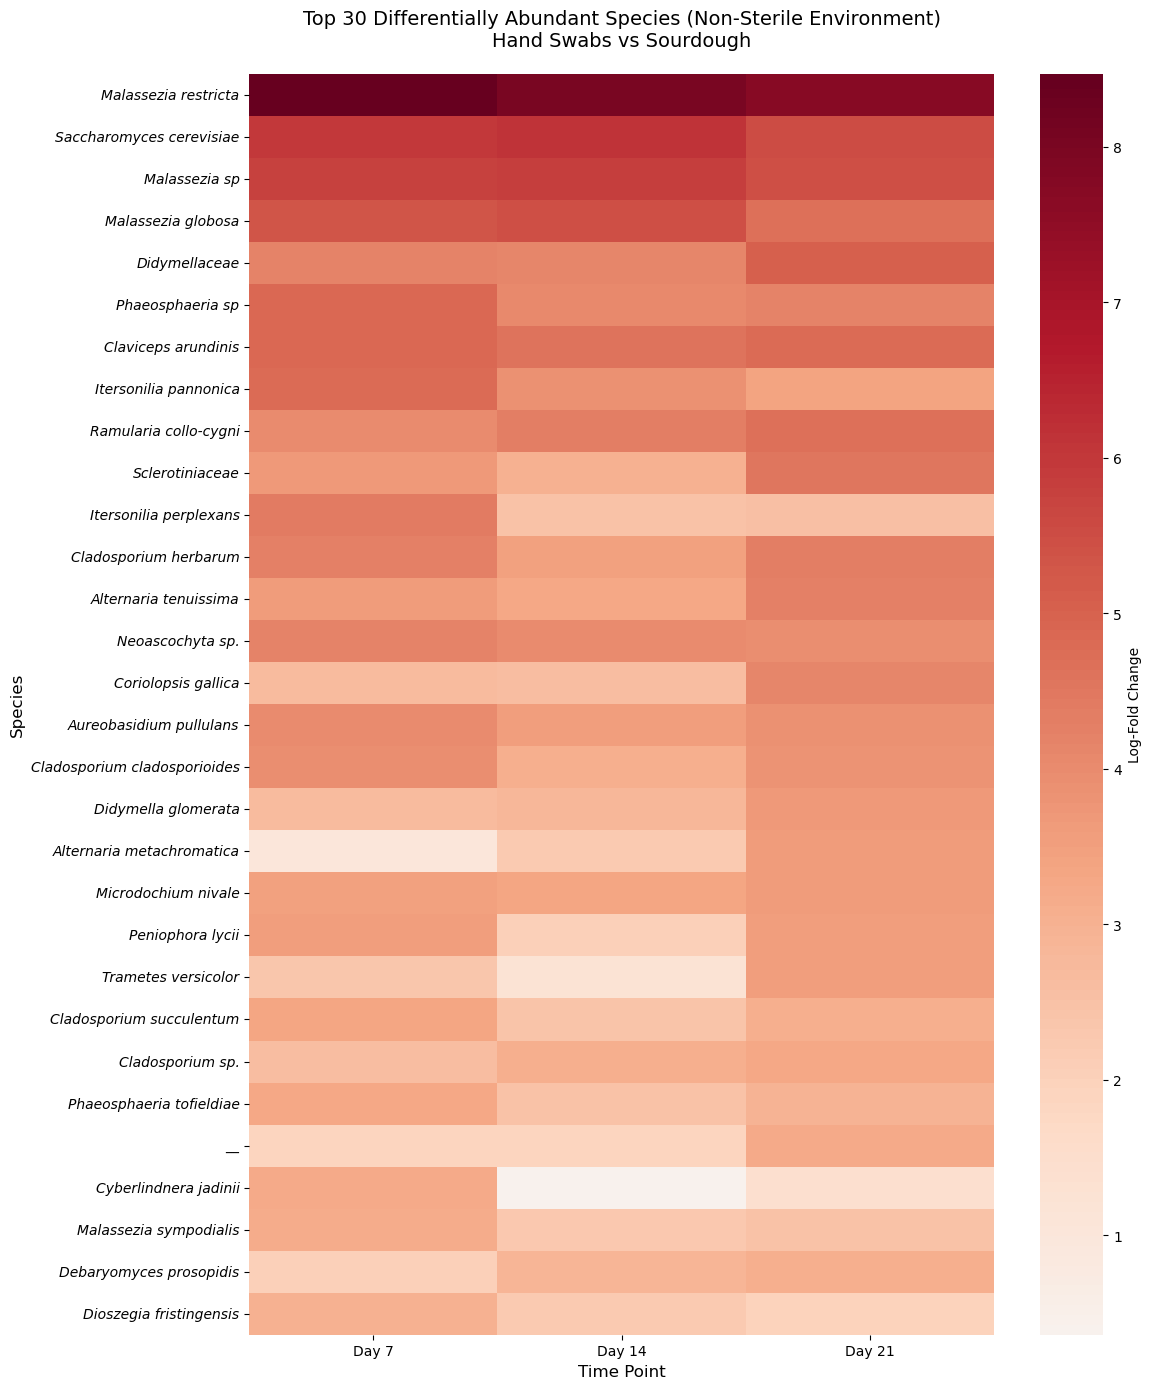

In [25]:
#Create heatmap for NON-STERILE environment
# Combine all days and identify top 30 species by absolute log-fold change (NON-STERILE)
all_species_non_sterile = []
for day, df in results_species_level_non_sterile.items():
    df_sig = df[df['q_val'] < 0.05].copy()
    df_sig['abs_lfc'] = df_sig['lfc'].abs()
    df_sig['day'] = day
    all_species_non_sterile.append(df_sig)

combined_non_sterile = pd.concat(all_species_non_sterile)
top_species_non_sterile = combined_non_sterile.groupby('id')['abs_lfc'].max().nlargest(30).index

# Create matrix for heatmap (rows = species, columns = days)
heatmap_data_non_sterile = pd.DataFrame(index=top_species_non_sterile, columns=days)
for day in days:
    df = results_species_level_non_sterile[day].set_index('id')
    for species in top_species_non_sterile:
        if species in df.index:
            heatmap_data_non_sterile.loc[species, day] = df.loc[species, 'lfc']
        else:
            heatmap_data_non_sterile.loc[species, day] = 0

heatmap_data_non_sterile = heatmap_data_non_sterile.astype(float)

# Extract only genus and species from the full taxonomy
def extract_genus_species(full_taxonomy):
    """Extract genus and species from full taxonomy string, showing species epithet only"""
    parts = full_taxonomy.split(';')
    genus = ''
    species = ''
    family = ''
    
    for part in parts:
        part = part.strip()
        if part.startswith('f__'):
            family = part.replace('f__', '').strip()
        elif part.startswith('g__'):
            genus = part.replace('g__', '').strip()
        elif part.startswith('s__'):
            species_full = part.replace('s__', '').strip()
            # Extract only the species epithet (second word)
            species_parts = species_full.split('_')
            if len(species_parts) >= 2:
                species = species_parts[1]  # Get second part (species epithet)
            else:
                species = species_full
    
    if genus and species:
        return f"{genus} {species}"
    elif genus:
        return f"{genus} sp."  # Genus level only
    elif family:
        return family  # Family level only
    else:
        # If nothing found, return last identifiable part
        return full_taxonomy.split(';')[-1].strip()

# Create simplified labels
simplified_labels_non_sterile = [extract_genus_species(tax) for tax in heatmap_data_non_sterile.index]

# Create the heatmap for non-sterile environment
plt.figure(figsize=(12, 14))
ax = sns.heatmap(heatmap_data_non_sterile, cmap='RdBu_r', center=0, 
            cbar_kws={'label': 'Log-Fold Change'},
            xticklabels=[f'Day {d}' for d in days],
            yticklabels=simplified_labels_non_sterile)

# Make species names italic
for label in ax.get_yticklabels():
    label.set_fontstyle('italic')

plt.title('Top 30 Differentially Abundant Species (Non-Sterile Environment)\nHand Swabs vs Sourdough', 
          fontsize=14, pad=20)
plt.xlabel('Time Point', fontsize=12)
plt.ylabel('Species', fontsize=12)
plt.tight_layout()
plt.show()

In [16]:
#here also need to adjust path for sterile and non-sterile once 
# Load the differential species abundance results for each time point (hand_swabs vs sourdough)
days = [7, 14, 21]  # Exclude day 0 since it failed
results_hand_vs_sourdough = {}

for day in days:
    lfc = pd.read_csv(f"{data_abundance}/exported_hand_vs_sourdough_l7_day{day}/lfc_slice.csv", index_col=0)
    p_val = pd.read_csv(f"{data_abundance}/exported_hand_vs_sourdough_l7_day{day}/p_val_slice.csv", index_col=0)
    q_val = pd.read_csv(f"{data_abundance}/exported_hand_vs_sourdough_l7_day{day}/q_val_slice.csv", index_col=0)
    se = pd.read_csv(f"{data_abundance}/exported_hand_vs_sourdough_l7_day{day}/se_slice.csv", index_col=0)
    w = pd.read_csv(f"{data_abundance}/exported_hand_vs_sourdough_l7_day{day}/w_slice.csv", index_col=0)
    
    df = pd.DataFrame({
        'lfc': lfc.iloc[:, 0],
        'p_val': p_val.iloc[:, 0],
        'q_val': q_val.iloc[:, 0],
        'se': se.iloc[:, 0],
        'w': w.iloc[:, 0]
    })
    df.index.name = 'id'
    df = df.reset_index()
    results_hand_vs_sourdough[day] = df

# Quick check
for day in days:
    significant = results_hand_vs_sourdough[day][results_hand_vs_sourdough[day]['q_val'] < 0.05]
    print(f"Day {day}: {len(significant)} significant taxa")
    print(f"  Enriched in sourdough: {(significant['lfc'] > 0).sum()}")
    print(f"  Enriched in hand_swabs: {(significant['lfc'] < 0).sum()}\n")

Day 7: 90 significant taxa
  Enriched in sourdough: 68
  Enriched in hand_swabs: 22

Day 14: 115 significant taxa
  Enriched in sourdough: 74
  Enriched in hand_swabs: 41

Day 21: 114 significant taxa
  Enriched in sourdough: 96
  Enriched in hand_swabs: 18

